# "Pump it Up: Data Mining the Water Table"

Data Understanding & Statistical Analysis

Jason & Tom

In [1]:
# Imports

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import string

# Data Understanding & Statistical Analysis

This notebook explains the steps we took to initially understand our data. We also produced some statistical analysis on each colum.

We both took different steps to do this, and collated our findings at the end. Cells by one author only will contain ``` Written By [Author] ``` at the top. Cells without this tag were steps taken by both of us, unless specified.

In [2]:
df_values = pd.read_csv('./datasets/train_features_water.csv')
df_labels = pd.read_csv('./datasets/train_labels_water.csv')
df = df_values.merge(df_labels, on='id', how='left')

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## 1.0 Initial Understanding / Data Quality Assesment

In [4]:
df.shape

(59400, 41)

In [5]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Some notes on ```df.describe()```

amount_tsh (total vertical distance pump carries the water from source to tap (m))

    - max value of 350000 seems excessively high, we should look into that
    - especially when the max gps height is only 2770m (gps height is height of pump from sea-level).
   

population

    - why is min & 25% = 0, what does this mean - is this an error or is there actually no people in these areas

construction_year

    - a lot of 0 values, we will definitely need to impute this, perhaps based off waterpoint type/district rather than the mean (although we can try both).

In [6]:
# percent of data that has construction year 0

df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0] * 100

34.86363636363636

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [8]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]

null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


Some notes on missing data:

    - scheme_name has too many missing values to be useful, we should drop this column.
    - scheme_management - this is a useful column so we shouldn't drop it, we could either replace all missing values with 'Other', (as we will likely have to do that anyway)
    - installer - same as scheme_management
    - funder - same as scheme_management
    - public_meeting - more information needed
    - permit - more information needed
    - subvillage we can impute based off other geographical data, perhaps using clustering, or we can drop as there might be too many unique values.

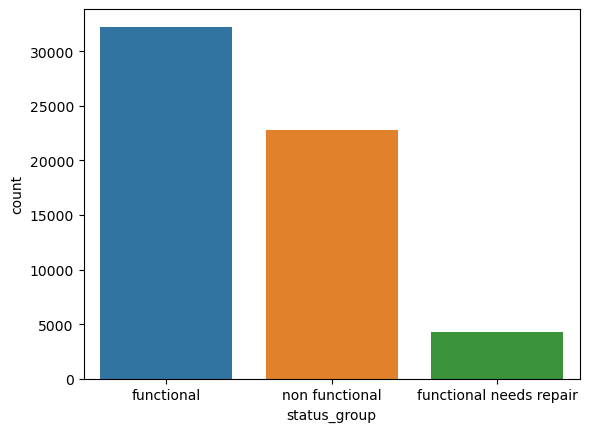

In [9]:
sns.countplot(data=df, x='status_group')
plt.show()

## 1.1 Checking Each Columns Values & Quality

**Unless specified, everything in section 1.1 was performed by Jason.**

### 1.1.1 Amount_tsh

In [10]:
df['amount_tsh'].value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
6300.0          1
120000.0        1
138000.0        1
350000.0        1
59.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [11]:
print('Missing Values of Amount_tsh Column:', df['amount_tsh'].isna().sum())

print('Unique Values of Amount_tsh Column:', len(df['amount_tsh'].unique()))

Missing Values of Amount_tsh Column: 0
Unique Values of Amount_tsh Column: 98


### 1.1.2 Funder

In [12]:
df['funder'].value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Rarymond Ekura               1
Justine Marwa                1
Municipal Council            1
Afdp                         1
Samlo                        1
Name: funder, Length: 1897, dtype: int64

In [13]:
print('Missing Values of Funder Column:', df['funder'].isna().sum())

print('Unique Values of Funder Column:', len(df['funder'].unique()))

Missing Values of Funder Column: 3635
Unique Values of Funder Column: 1898


### 1.1.3 GPS_Height

In [14]:
df['gps_height'].value_counts()

 0       20438
-15         60
-16         55
-13         55
 1290       52
         ...  
 2378        1
-54          1
 2057        1
 2332        1
 2366        1
Name: gps_height, Length: 2428, dtype: int64

In [15]:
print('Missing Values of GPS_Height Column:', df['gps_height'].isna().sum())

print('Unique Values of GPS_Height Column:', len(df['gps_height'].unique()))

Missing Values of GPS_Height Column: 0
Unique Values of GPS_Height Column: 2428


### 1.1.4 Installer

In [16]:
df['installer'].value_counts()

DWE                17402
Government          1825
RWE                 1206
Commu               1060
DANIDA              1050
                   ...  
Wizara  ya maji        1
TWESS                  1
Nasan workers          1
R                      1
SELEPTA                1
Name: installer, Length: 2145, dtype: int64

In [17]:
print('Missing Values of Installer Column:', df['installer'].isna().sum())

print('Unique Values of Installer Column:', len(df['installer'].unique()))

Missing Values of Installer Column: 3655
Unique Values of Installer Column: 2146


### 1.1.5 Longitude

In [18]:
df['longitude'].value_counts()

0.000000     1812
37.375717       2
38.340501       2
39.086183       2
33.005032       2
             ... 
35.885754       1
36.626541       1
37.333530       1
38.970078       1
38.104048       1
Name: longitude, Length: 57516, dtype: int64

In [19]:
print('Missing Values of Longitude Column:', df['longitude'].isna().sum())

print('Unique Values of Longitude Column:', len(df['longitude'].unique()))

Missing Values of Longitude Column: 0
Unique Values of Longitude Column: 57516


### 1.1.6 Latitude

In [20]:
df['latitude'].value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-6.980220e+00       2
-2.476680e+00       2
-6.978263e+00       2
                 ... 
-3.287619e+00       1
-8.234989e+00       1
-3.268579e+00       1
-1.146053e+01       1
-6.747464e+00       1
Name: latitude, Length: 57517, dtype: int64

In [21]:
print('Missing Values of Latitude Column:', df['latitude'].isna().sum())

print('Unique Values of Latitude Column:', len(df['latitude'].unique()))

Missing Values of Latitude Column: 0
Unique Values of Latitude Column: 57517


### 1.1.7 Waterpoint Name

In [22]:
df['wpt_name'].value_counts()

none                       3563
Shuleni                    1748
Zahanati                    830
Msikitini                   535
Kanisani                    323
                           ... 
Kwa Medadi                    1
Kwa Kubembeni                 1
Shule Ya Msingi Milanzi       1
Funua                         1
Kwa Mzee Lugawa               1
Name: wpt_name, Length: 37400, dtype: int64

In [23]:
print('Missing Values of Waterpoint Name Column:', df['wpt_name'].isna().sum())

print('Unique Values of Waterpoint Name Column:', len(df['wpt_name'].unique()))

Missing Values of Waterpoint Name Column: 0
Unique Values of Waterpoint Name Column: 37400


### 1.1.8 Num_private

In [24]:
df['num_private'].value_counts()

0       58643
6          81
1          73
5          46
8          46
        ...  
42          1
23          1
136         1
698         1
1402        1
Name: num_private, Length: 65, dtype: int64

In [25]:
print('Missing Values of Num_private Name Column:', df['num_private'].isna().sum())

print('Unique Values of Num_private Name Column:', len(df['num_private'].unique()))

Missing Values of Num_private Name Column: 0
Unique Values of Num_private Name Column: 65


### 1.1.9 Basin

In [26]:
df['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [27]:
print('Missing Values of Basin Name Column:', df['basin'].isna().sum())

print('Unique Values of Basin Name Column:', len(df['basin'].unique()))

Missing Values of Basin Name Column: 0
Unique Values of Basin Name Column: 9


### 1.1.10 Subvillage 

In [28]:
df['subvillage'].value_counts()

Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: subvillage, Length: 19287, dtype: int64

In [29]:
print('Missing Values of Subvillage Column:', df['subvillage'].isna().sum())

print('Unique Values of Subvillage Column:', len(df['subvillage'].unique()))

Missing Values of Subvillage Column: 371
Unique Values of Subvillage Column: 19288


### 1.1.11 Region

In [30]:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

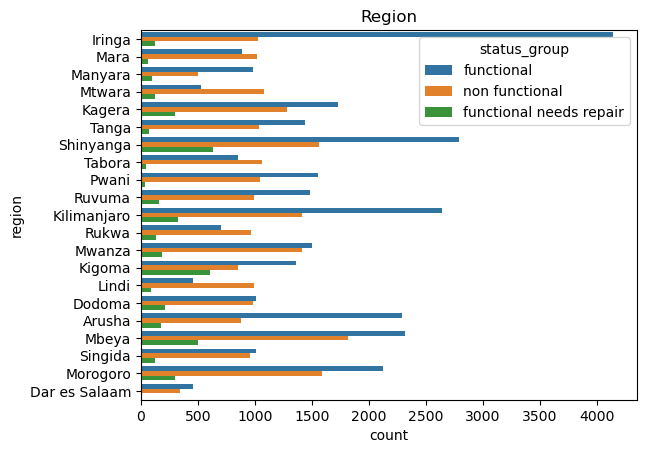

In [31]:
sns.countplot(data=df, y='region', hue='status_group', dodge=1.0)
plt.title('Region')
plt.show()

### 1.1.12 Region Code

In [32]:
df['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [33]:
print('Missing Values of Region Code Column:', df['region_code'].isna().sum())

print('Unique Values of Region Code Column:', len(df['region_code'].unique()))

Missing Values of Region Code Column: 0
Unique Values of Region Code Column: 27


### 1.1.13 District Code

In [34]:
df['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [35]:
print('Missing Values of District Code Column:', df['district_code'].isna().sum())

print('Unique Values of District Code Column:', len(df['district_code'].unique()))

Missing Values of District Code Column: 0
Unique Values of District Code Column: 20


### 1.1.14 LGA

In [36]:
df['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [37]:
print('Missing Values of LGA Column:', df['lga'].isna().sum())

print('Unique Values of LGA Column:', len(df['lga'].unique()))

Missing Values of LGA Column: 0
Unique Values of LGA Column: 125


### 1.1.15 Ward

In [38]:
df['ward'].value_counts()

Igosi              307
Imalinyi           252
Siha Kati          232
Mdandu             231
Nduruma            217
                  ... 
Uchindile            1
Thawi                1
Uwanja wa Ndege      1
Izia                 1
Kinungu              1
Name: ward, Length: 2092, dtype: int64

In [39]:
print('Missing Values of Ward Column:', df['ward'].isna().sum())

print('Unique Values of Ward Column:', len(df['ward'].unique()))

Missing Values of Ward Column: 0
Unique Values of Ward Column: 2092


### 1.1.16 Population

In [40]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: population, Length: 1049, dtype: int64

In [41]:
print('Missing Values of Population Column:', df['population'].isna().sum())

print('Unique Values of Population Column:', len(df['population'].unique()))

Missing Values of Population Column: 0
Unique Values of Population Column: 1049


### 1.1.17 Public Meeting

In [42]:
df['public_meeting'].value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [43]:
print('Missing Values of Public Meeting Column:', df['public_meeting'].isna().sum())

Missing Values of Public Meeting Column: 3334


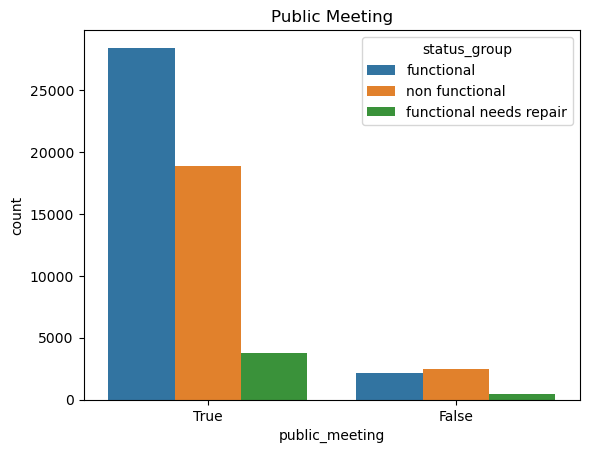

In [44]:
sns.countplot(data=df, x='public_meeting', hue='status_group', dodge=1.0)
plt.title('Public Meeting')
plt.show()

### 1.1.18 Recorded By

In [45]:
df['recorded_by'].value_counts()

GeoData Consultants Ltd    59400
Name: recorded_by, dtype: int64

In [46]:
print('Missing Values of Recorded By Column:', df['recorded_by'].isna().sum())

Missing Values of Recorded By Column: 0


### 1.1.19 Scheme Management

In [47]:
df['scheme_management'].value_counts()

VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [48]:
df['scheme_management'].isna().sum()

3877

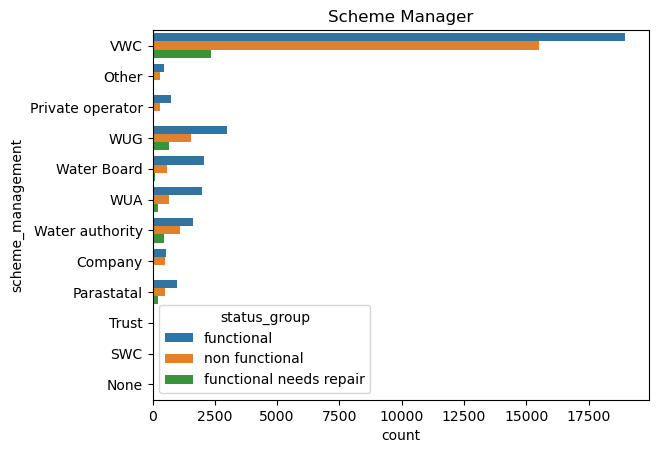

In [49]:
sns.countplot(data=df, y='scheme_management', hue='status_group', dodge=1.0)
plt.title('Scheme Manager')
plt.show()

### 1.1.20 Scheme Name

In [50]:
df['scheme_name'].value_counts()

K                       682
None                    644
Borehole                546
Chalinze wate           405
M                       400
                       ... 
Mradi wa maji Vijini      1
Villagers                 1
Magundi water supply      1
Saadani Chumv             1
Mtawanya                  1
Name: scheme_name, Length: 2696, dtype: int64

In [51]:
print('Missing Values of Scheme Name Column:', df['scheme_name'].isna().sum())

print('Unique Values of Scheme Name Column:', len(df['scheme_name'].unique()))

Missing Values of Scheme Name Column: 28166
Unique Values of Scheme Name Column: 2697


### 1.1.21 Permit

In [52]:
df['permit'].value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [53]:
print('Missing Values of Permit Column:', df['permit'].isna().sum())

Missing Values of Permit Column: 3056


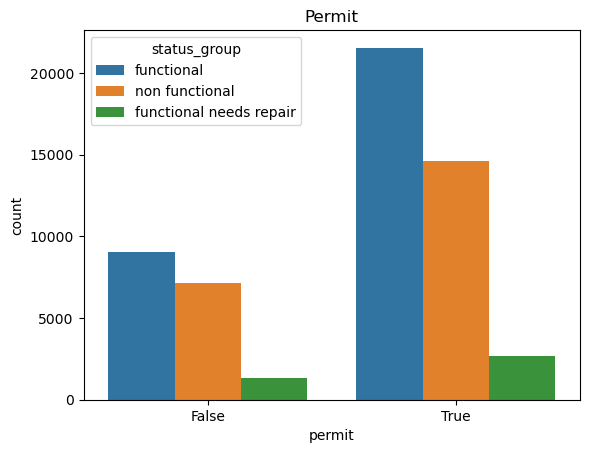

In [54]:
sns.countplot(data=df, x='permit', hue='status_group', dodge=1.0)
plt.title('Permit')
plt.show()

### 1.1.22 Construction Year

In [55]:
df.sort_values(by='construction_year', inplace=True)
df['construction_year'].unique()

array([   0, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969,
       1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980,
       1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013],
      dtype=int64)

In [56]:
df['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

Text(0, 0.5, 'No of Instances')

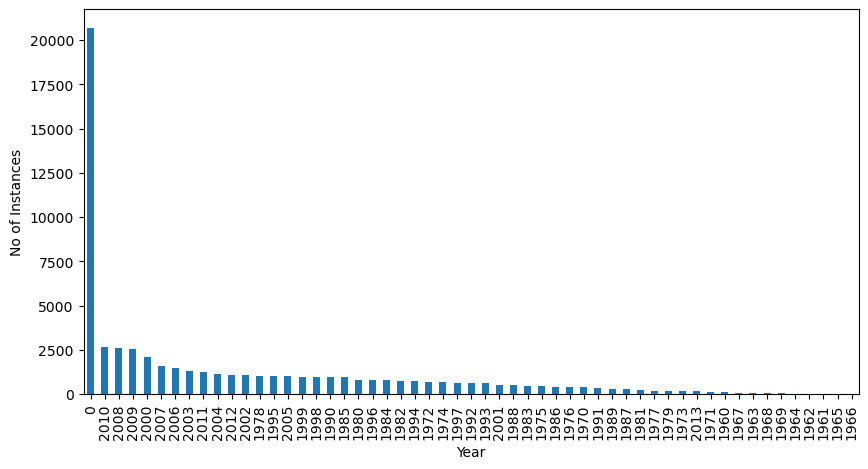

In [57]:
plt.figure(figsize=(10,5))
df['construction_year'].value_counts().plot(kind="bar")
plt.xlabel("Year")
plt.ylabel("No of Instances")

Because of the number of 0's, we took some extra time to check the correlation of `construction_year` to other features, to see if we could use those features to impute the 0 values.

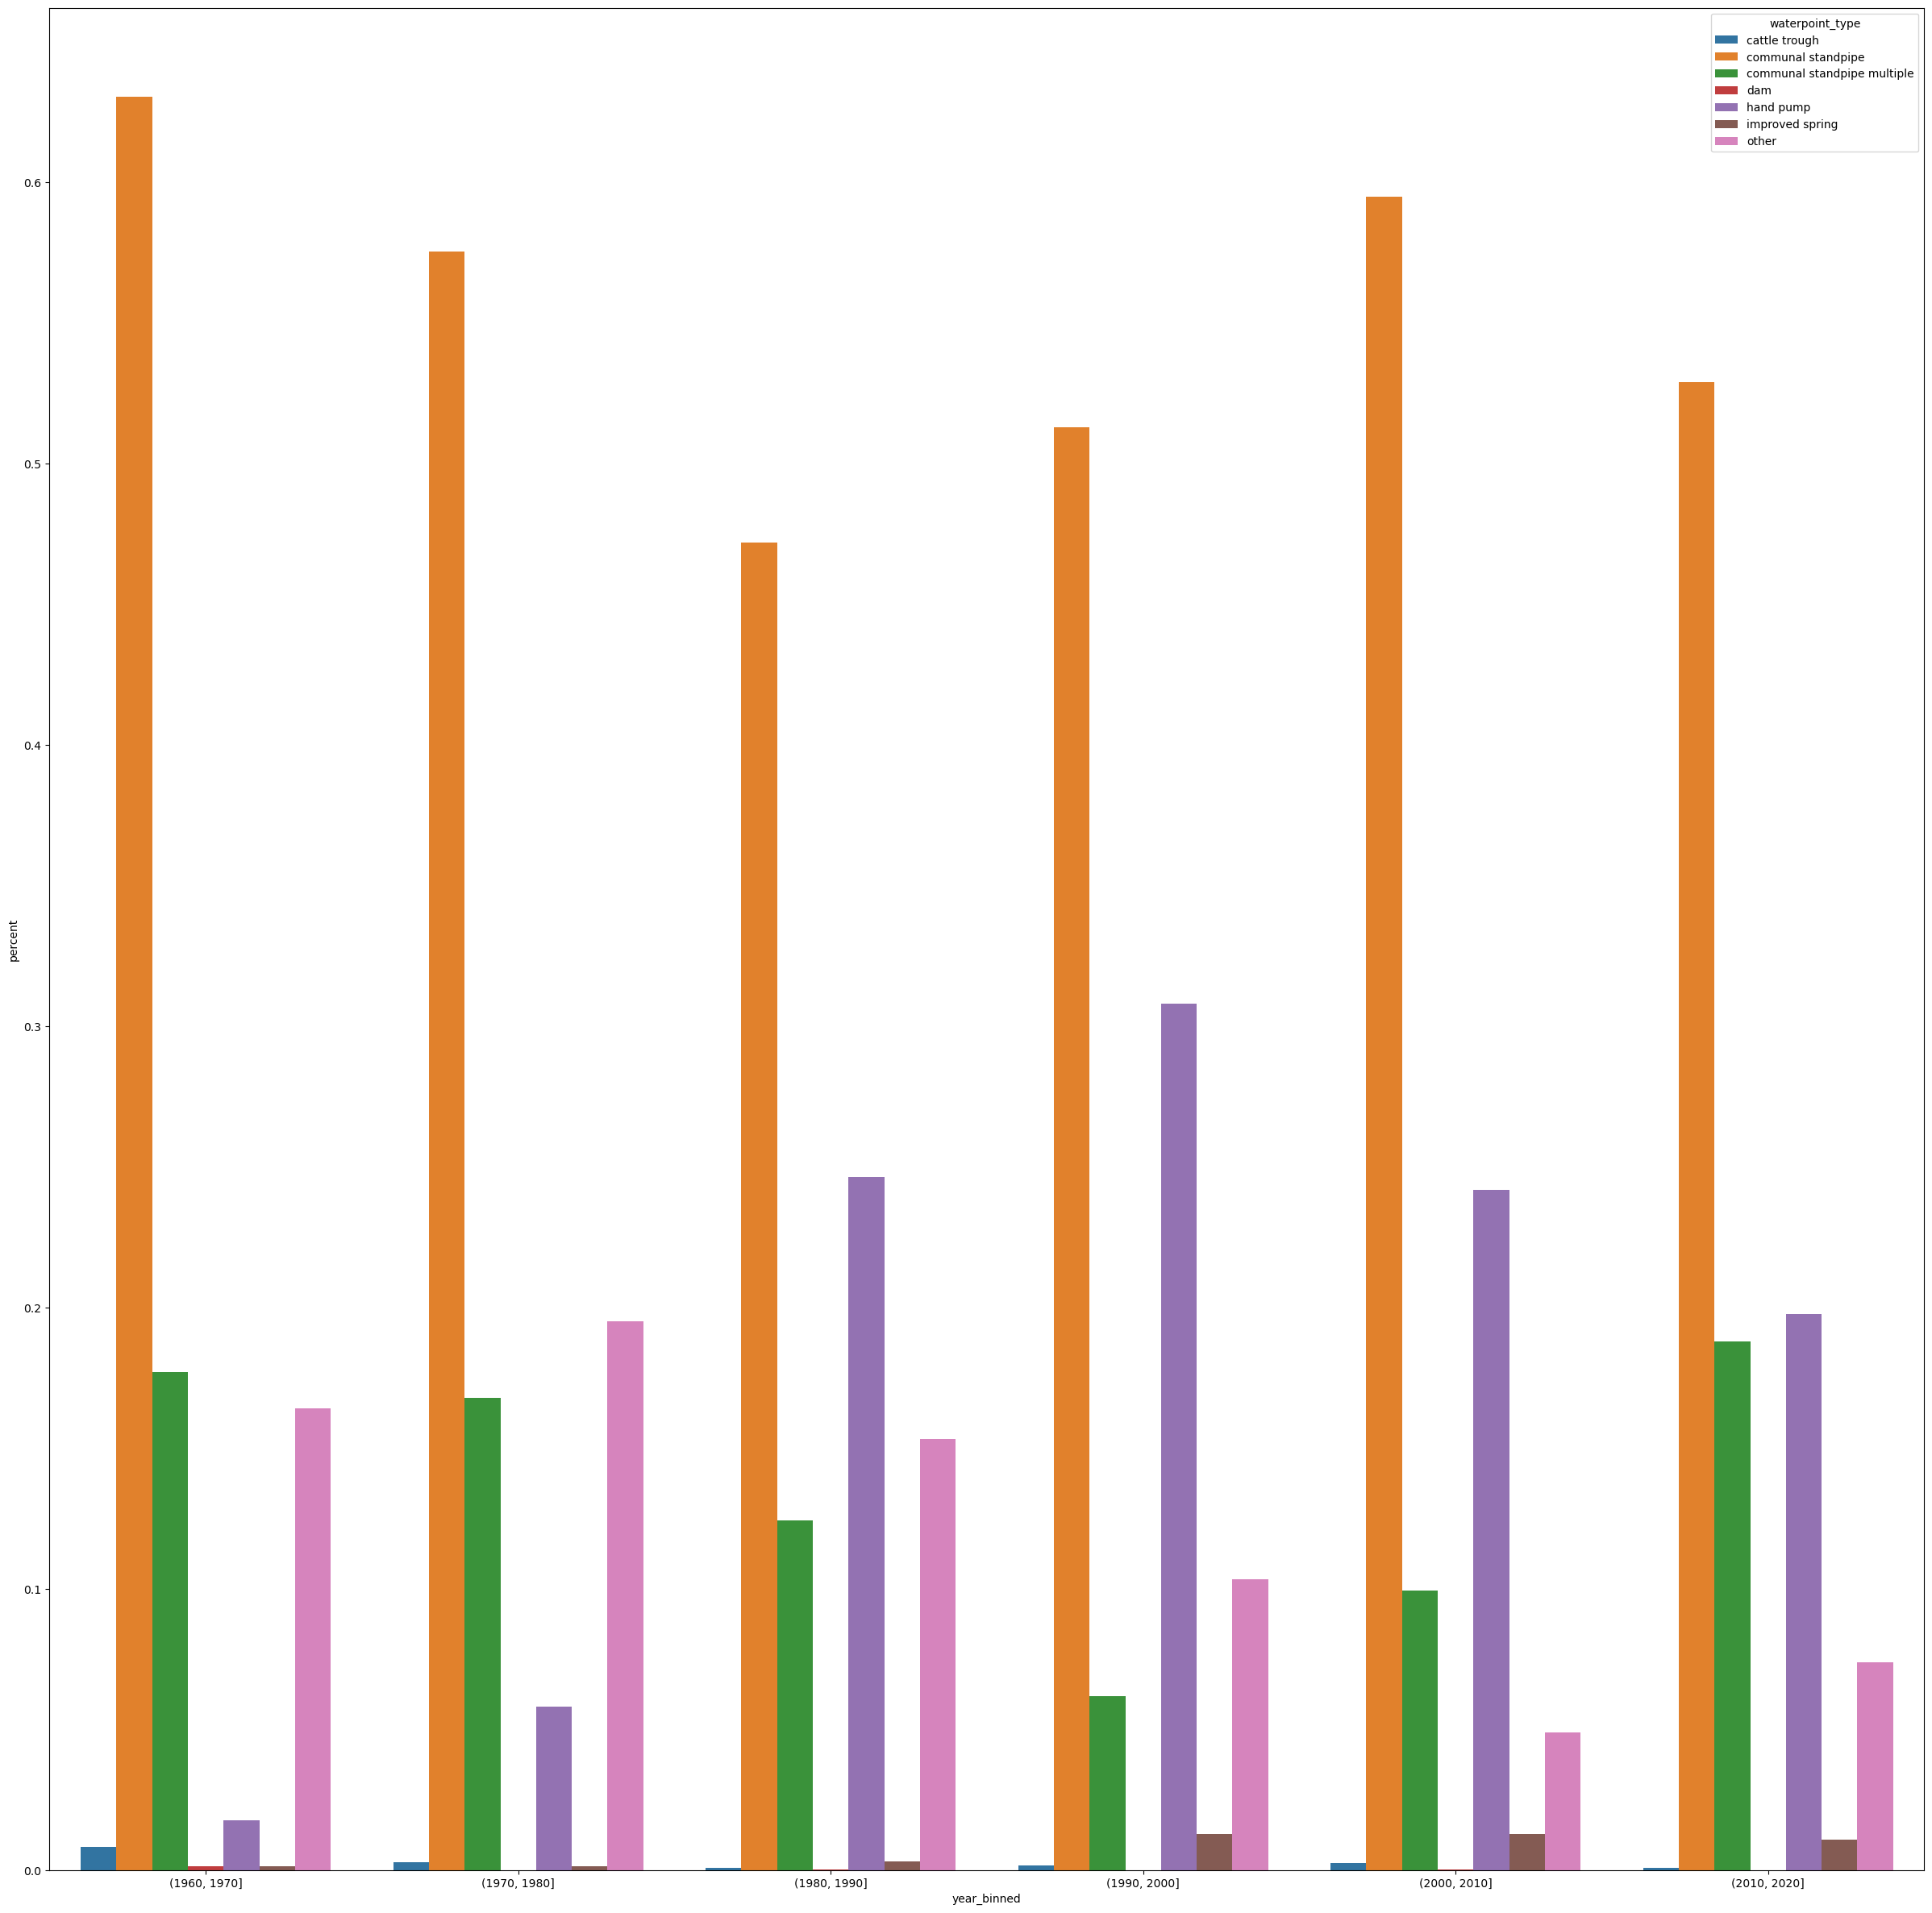

In [58]:
# Author [Tom]

# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

There doesn't seem to be much correlation between the waterpoint_type and construction year. There are two points:

    - 'other' usage goes down as time progresses
    - 'hand pump' usage goes up as time progresses

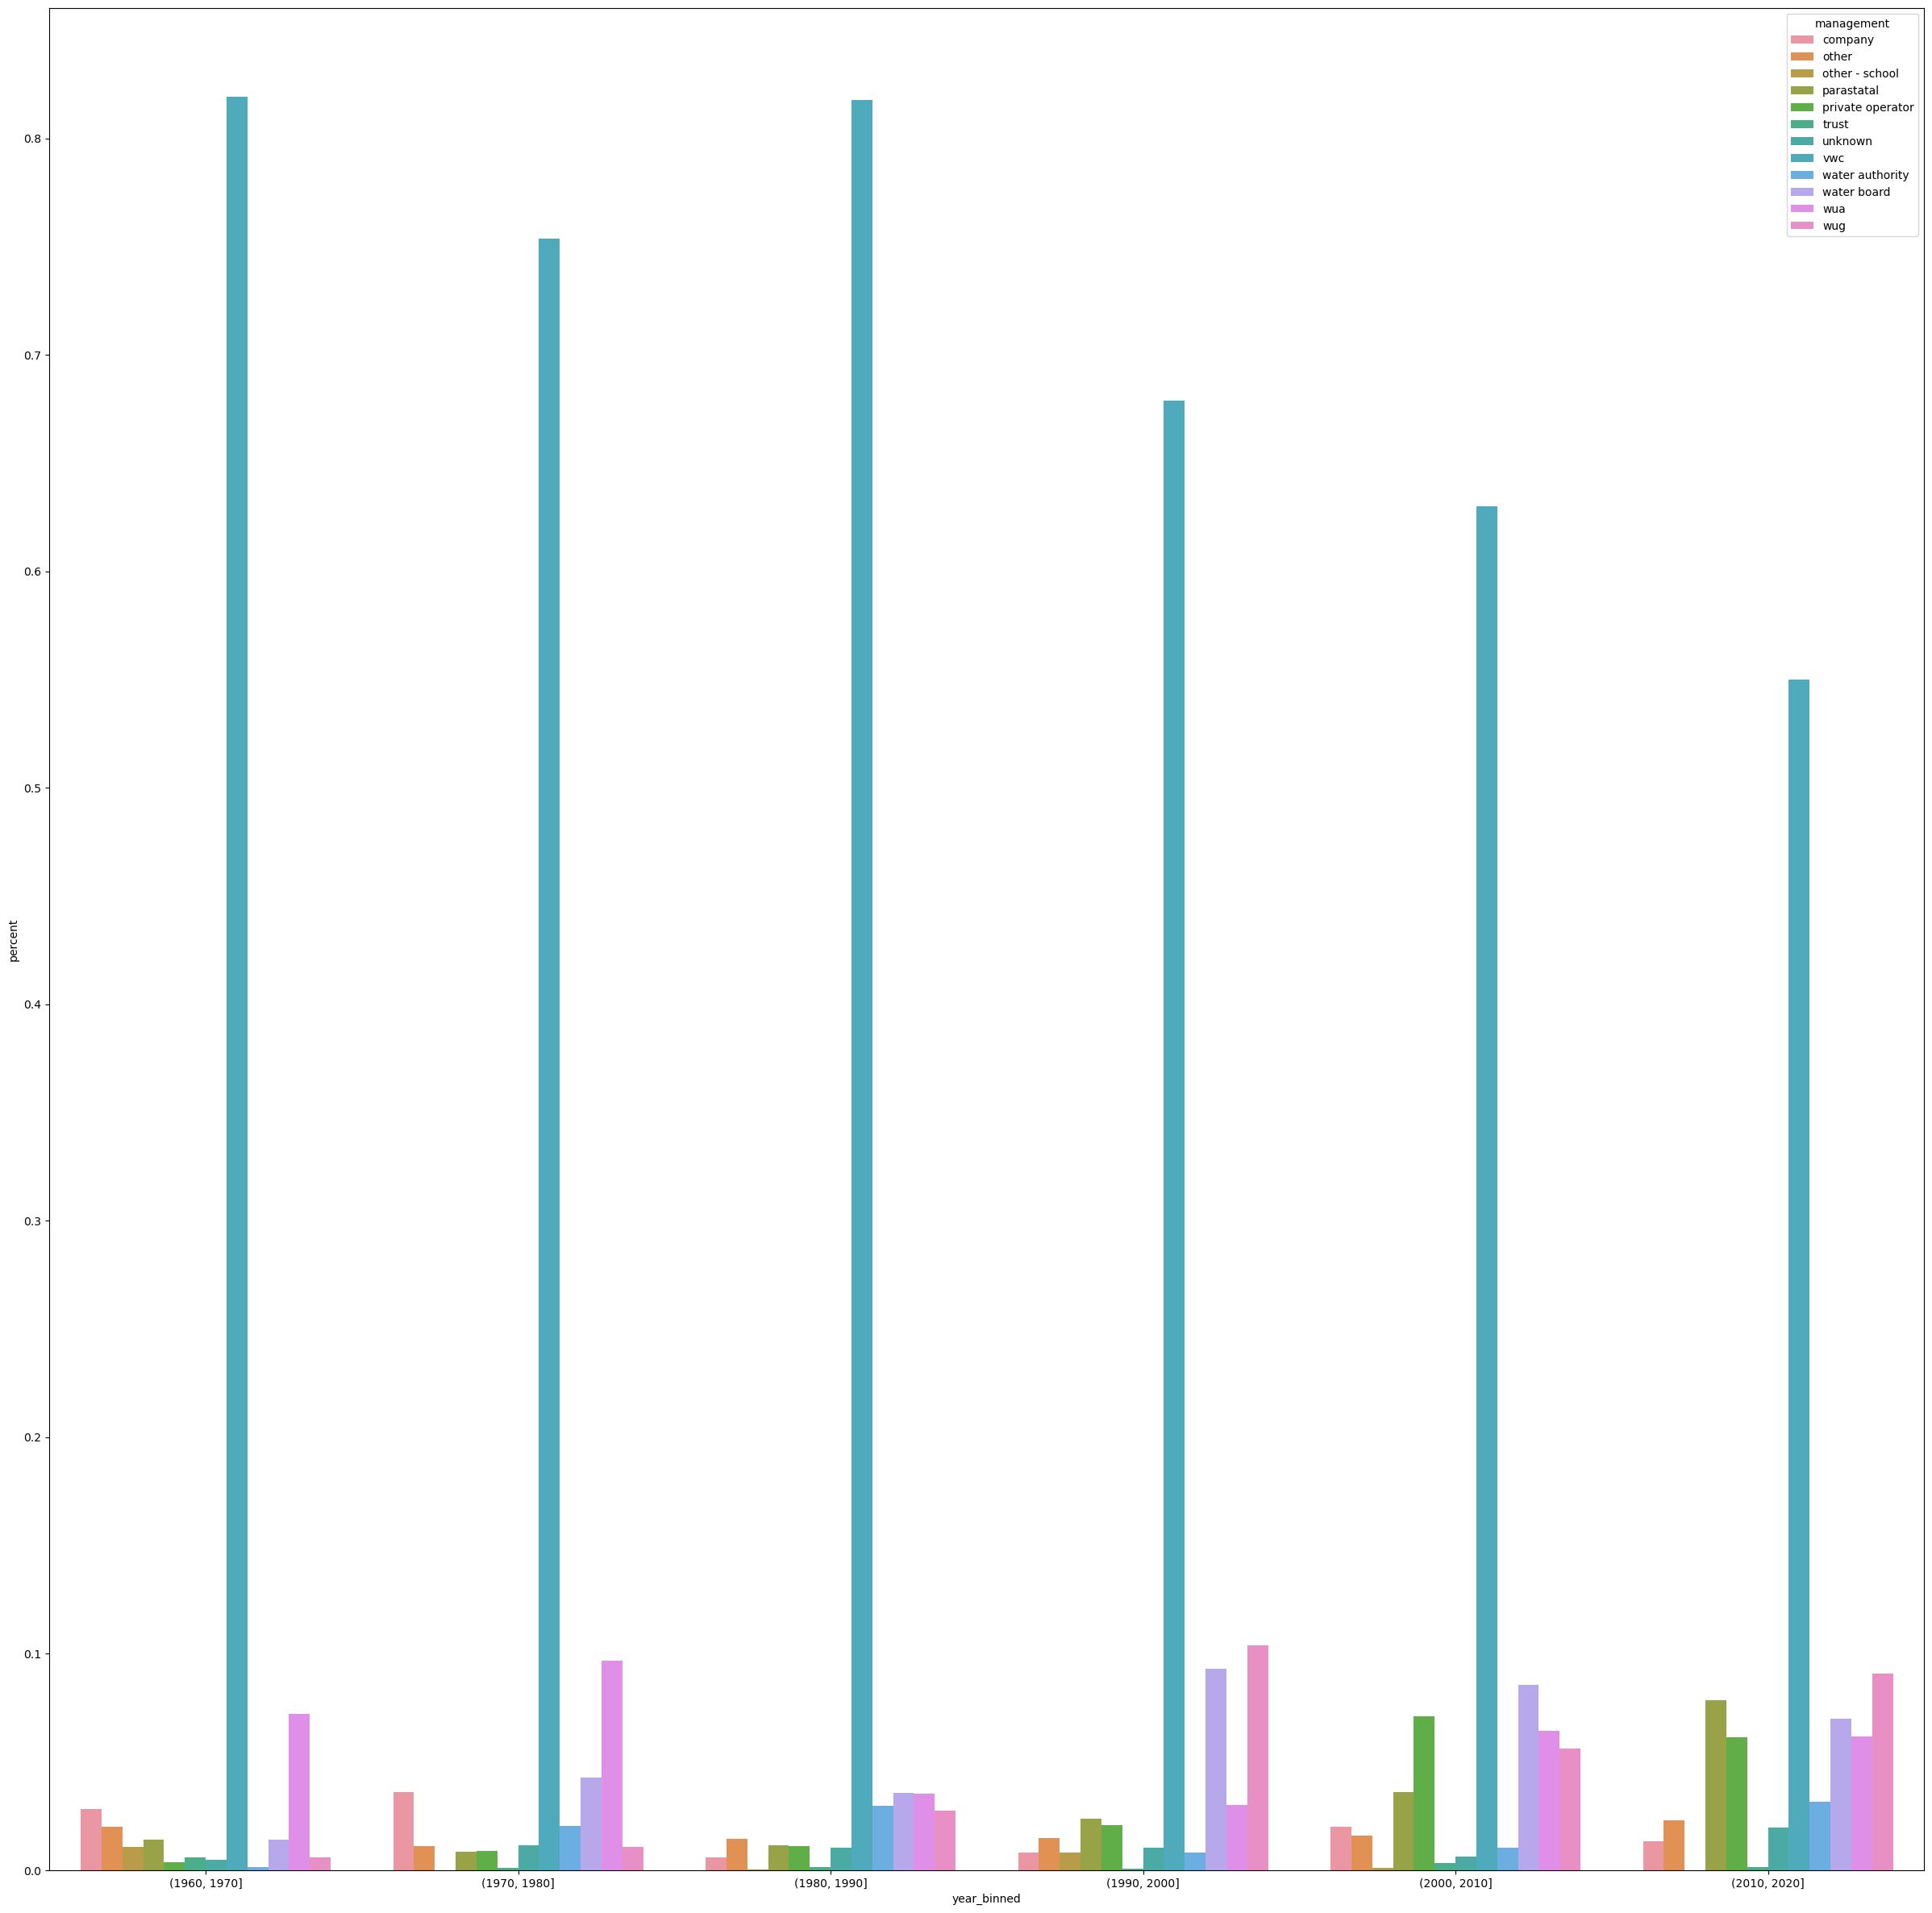

In [59]:
# Author [Tom]

df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

Interesting point here, 'parastatal' and 'private' definitely go up in percentage installed as the years increase.

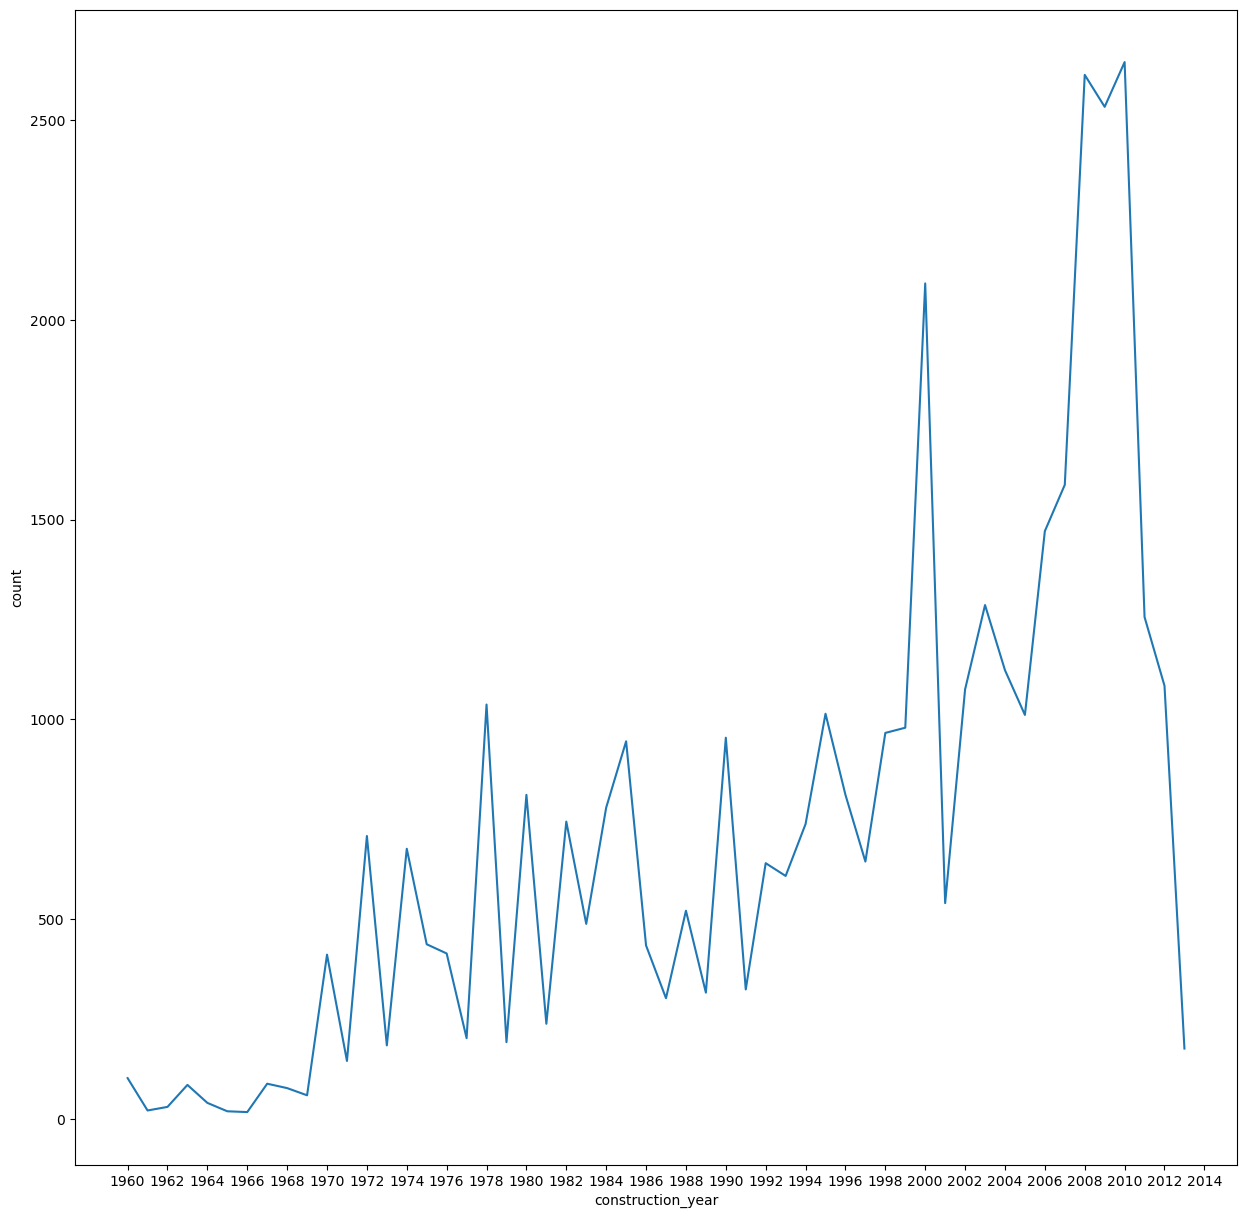

In [60]:
# Author [Tom]

df_years = df_test.groupby('construction_year').size().reset_index(name='count')
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

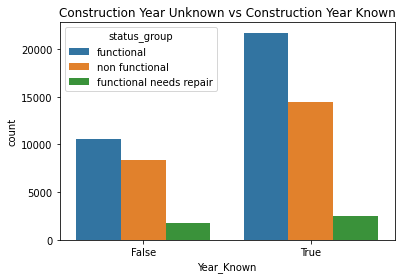

In [6]:
df_test = df.copy()
df_test['Year_Known'] = np.where(df_test['construction_year'] == 0, False, True)
sns.countplot(data=df_test, x='Year_Known', hue='status_group', dodge=1.0)
plt.title('Construction Year Unknown vs Construction Year Known')
plt.show()

### 1.1.23 Extraction_Type / Extraction_Type_Group / Extraction_Type_Class

In [61]:
df['extraction_type'].value_counts()

gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [62]:
df['extraction_type_group'].value_counts()

gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: extraction_type_group, dtype: int64

In [63]:
df['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [64]:
print('No of Extraction_Type Column Unique Values:', len(df['extraction_type'].unique()))

print('No of Extraction_Type_Group Column Unique Values:',len(df['extraction_type_group'].unique()))

print('No of Extraction_Type_Class Column Unique Values:',len(df['extraction_type_class'].unique()))

No of Extraction_Type Column Unique Values: 18
No of Extraction_Type_Group Column Unique Values: 13
No of Extraction_Type_Class Column Unique Values: 7


Text(0.5, 1.0, 'Extraction Type Class')

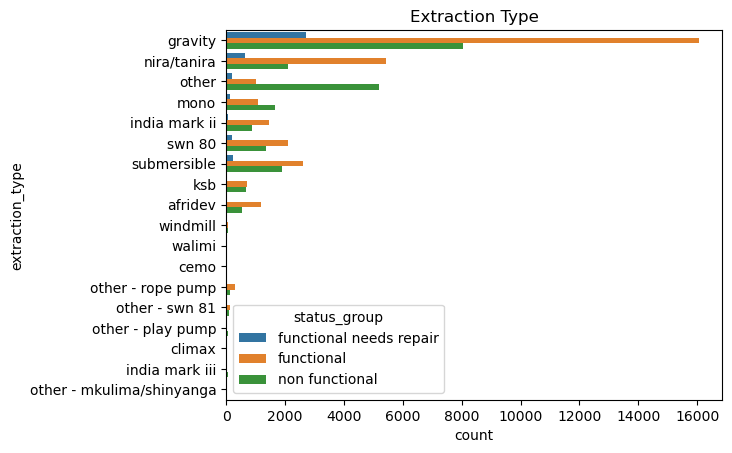

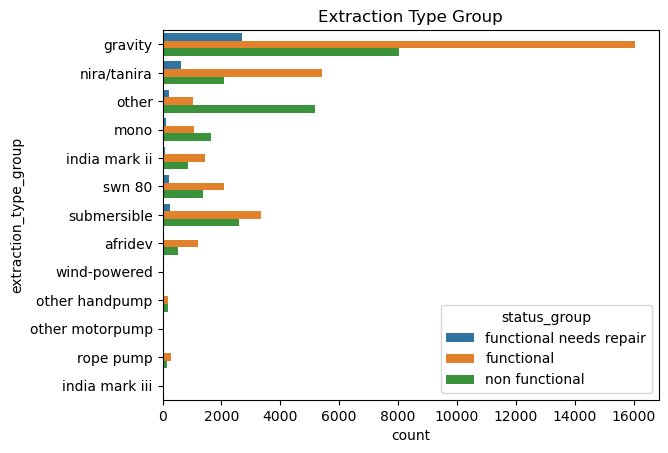

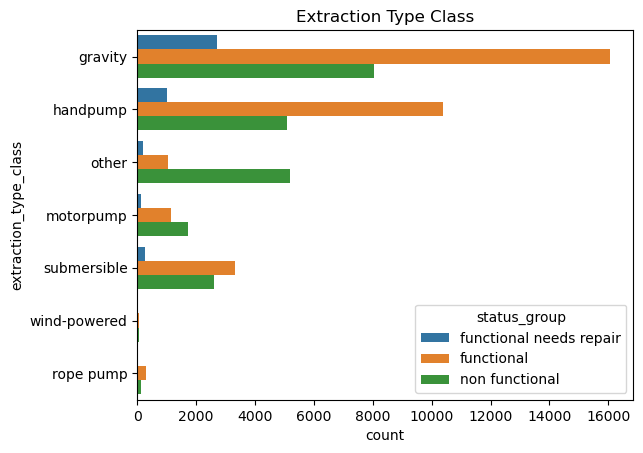

In [65]:
sns.countplot(data=df, y='extraction_type', hue='status_group', dodge=1.0)
plt.title('Extraction Type')

plt.figure()
sns.countplot(data=df, y='extraction_type_group', hue='status_group', dodge=1.0)
plt.title('Extraction Type Group')

plt.figure()
sns.countplot(data=df, y='extraction_type_class', hue='status_group', dodge=1.0)
plt.title('Extraction Type Class')

### 1.1.24 Management / Management Group

In [66]:
df['management'].value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [67]:
df['management_group'].value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [68]:
print('No of Management Column Unique Values:', len(df['management'].unique()))

print('No of Management_Group Column Unique Values:',len(df['management_group'].unique()))

No of Management Column Unique Values: 12
No of Management_Group Column Unique Values: 5


Text(0.5, 1.0, 'Management Group')

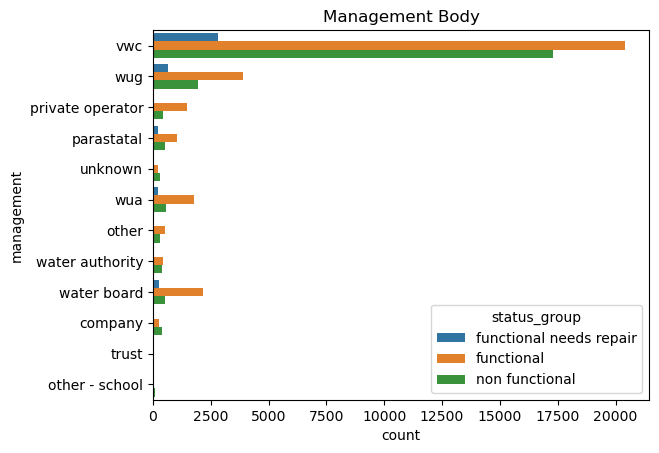

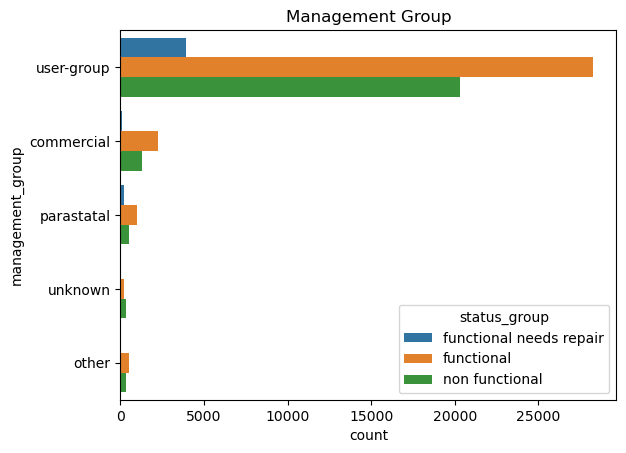

In [69]:
sns.countplot(data=df, y='management', hue='status_group', dodge=1.0)
plt.title('Management Body')

plt.figure()
sns.countplot(data=df, y='management_group', hue='status_group', dodge=1.0)
plt.title('Management Group')

### 1.1.25 Payment / Payment_Type

In [70]:
df['payment'].value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [71]:
df['payment_type'].value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [72]:
print('No of Payment Column Unique Values:', len(df['payment'].unique()))

print('No of Payment_Type Column Unique Values:',len(df['payment_type'].unique()))

No of Payment Column Unique Values: 7
No of Payment_Type Column Unique Values: 7


Text(0.5, 1.0, 'Payment Type')

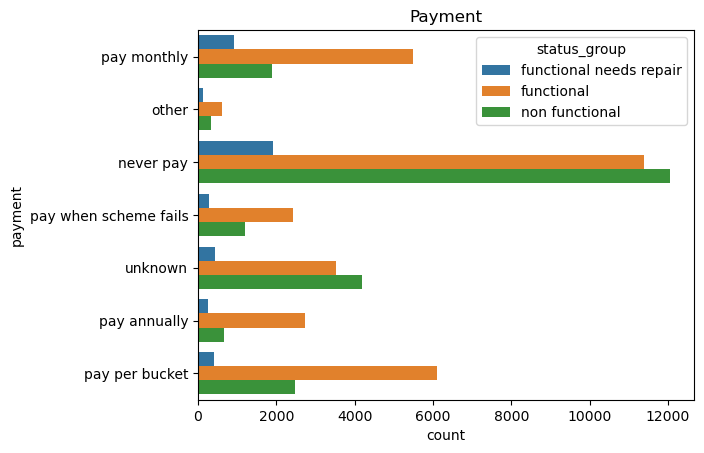

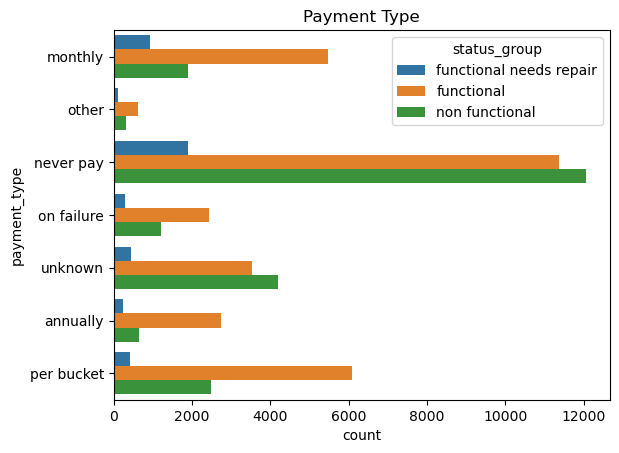

In [73]:
sns.countplot(data=df, y='payment', hue='status_group', dodge=1.0)
plt.title('Payment')

plt.figure()
sns.countplot(data=df, y='payment_type', hue='status_group', dodge=1.0)
plt.title('Payment Type')

### 1.1.26 Water_Quality / Quality_Group

In [74]:
df['water_quality'].value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [75]:
df['quality_group'].value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [76]:
print('No of Water_Quality Column Unique Values:', len(df['water_quality'].unique()))

print('No of Quality_Group Column Unique Values:',len(df['quality_group'].unique()))

No of Water_Quality Column Unique Values: 8
No of Quality_Group Column Unique Values: 6


Text(0.5, 1.0, 'Quality Group')

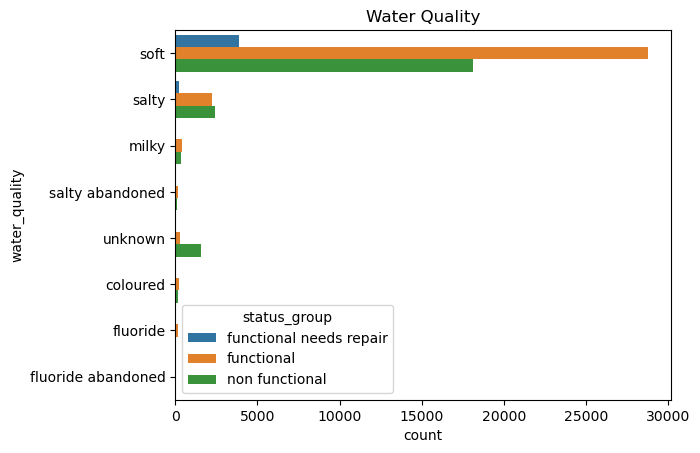

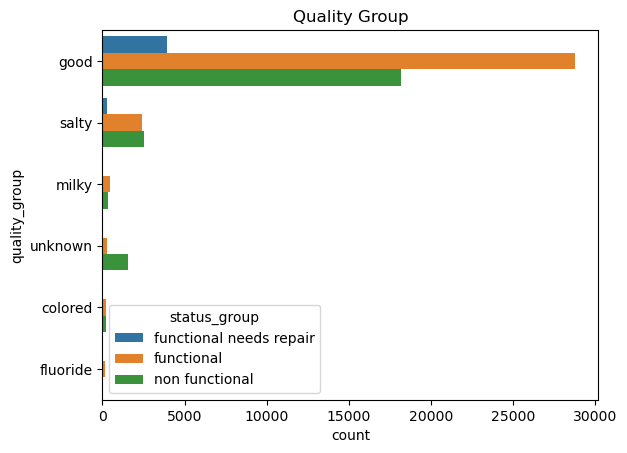

In [77]:
sns.countplot(data=df, y='water_quality', hue='status_group', dodge=1.0)
plt.title('Water Quality')

plt.figure()
sns.countplot(data=df, y='quality_group', hue='status_group', dodge=1.0)
plt.title('Quality Group')

### 1.1.27 Quantity / Quantity_Group

In [78]:
df['quantity'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [79]:
df['quantity_group'].value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [80]:
print('No of Quantity Column Unique Values:', len(df['quantity'].unique()))

print('No of Quantity_Group Column Unique Values:',len(df['quantity_group'].unique()))

No of Quantity Column Unique Values: 5
No of Quantity_Group Column Unique Values: 5


Text(0.5, 1.0, 'Quantity Group')

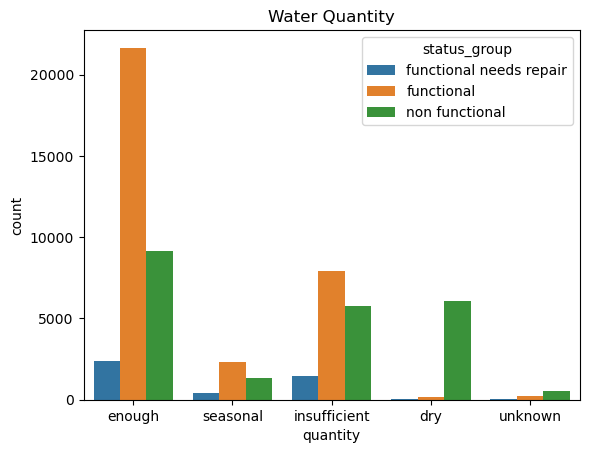

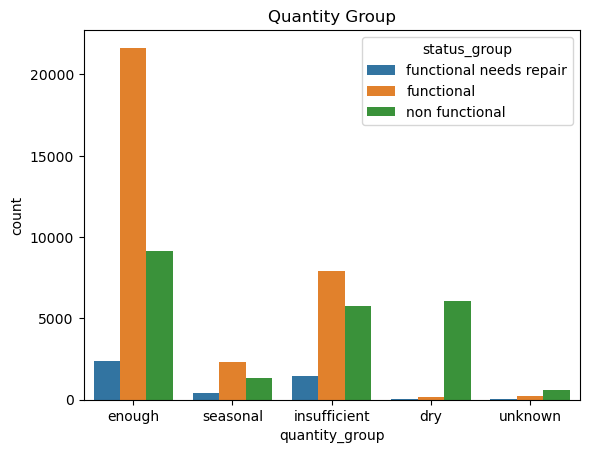

In [81]:
sns.countplot(data=df, x='quantity', hue='status_group', dodge=1.0)
plt.title('Water Quantity')

plt.figure()
sns.countplot(data=df, x='quantity_group', hue='status_group', dodge=1.0)
plt.title('Quantity Group')

### 1.1.28 Source / Source_Type / Source_Class

In [82]:
df['source'].value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [83]:
df['source_type'].value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [84]:
df['source_class'].value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [85]:
print('No of Source Column Unique Values:', len(df['source'].unique()))

print('No of Source_Type Column Unique Values:',len(df['source_type'].unique()))

print('No of Source_Class Column Unique Values:',len(df['source_class'].unique()))

No of Source Column Unique Values: 10
No of Source_Type Column Unique Values: 7
No of Source_Class Column Unique Values: 3


Text(0.5, 1.0, 'Source Class')

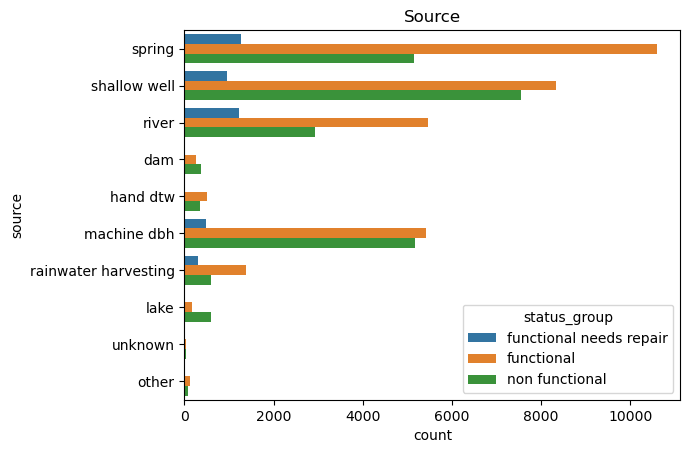

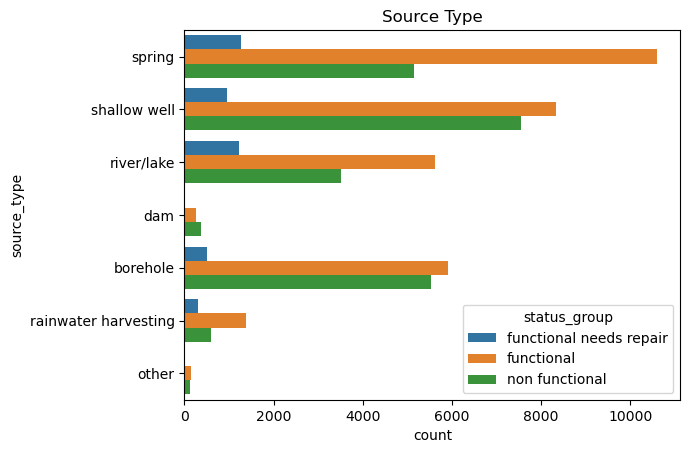

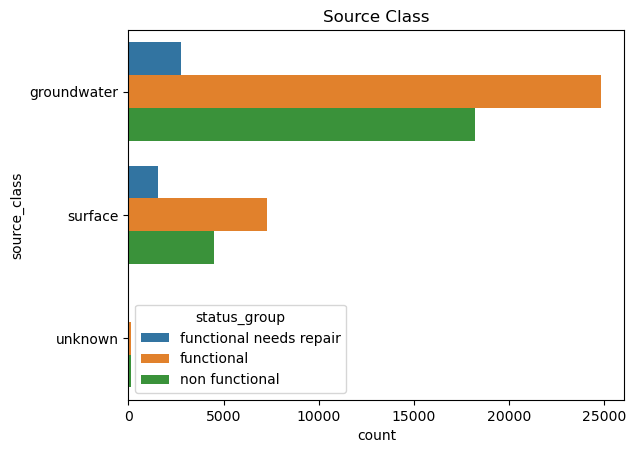

In [86]:
sns.countplot(data=df, y='source', hue='status_group', dodge=1.0)
plt.title('Source')

plt.figure()
sns.countplot(data=df, y='source_type', hue='status_group', dodge=1.0)
plt.title('Source Type')

plt.figure()
sns.countplot(data=df, y='source_class', hue='status_group', dodge=1.0)
plt.title('Source Class')

### 1.1.29 Waterpoint_Type / Waterpoint_Type_Group

In [87]:
df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [88]:
df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [89]:
print('No of Waterpoint_type unique values:' ,len(df['waterpoint_type'].unique()))

print('No of Waterpoint_type_group unique values:',len(df['waterpoint_type_group'].unique()))

No of Waterpoint_type unique values: 7
No of Waterpoint_type_group unique values: 6


Text(0.5, 1.0, 'Waterpoint Type Group')

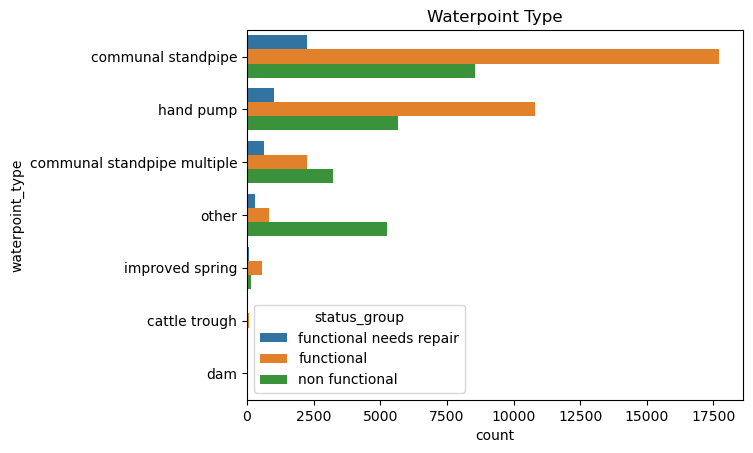

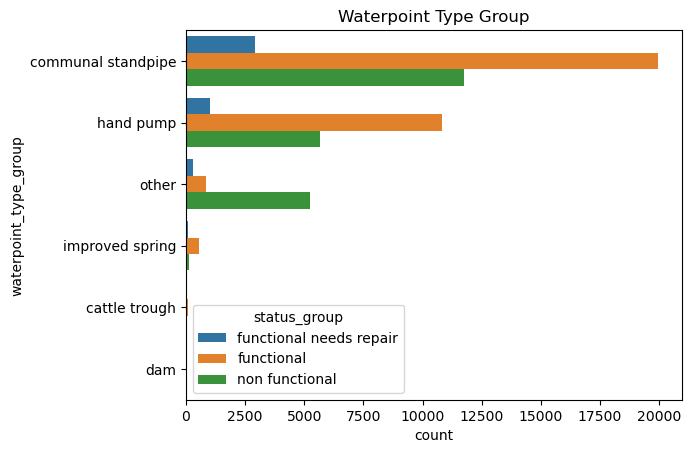

In [90]:
sns.countplot(data=df, y='waterpoint_type', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type')

plt.figure()
sns.countplot(data=df, y='waterpoint_type_group', hue='status_group', dodge=1.0)
plt.title('Waterpoint Type Group')

### 2.0 Additional Data Analysis

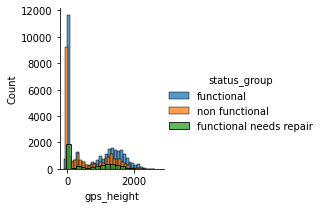

In [6]:
sns.FacetGrid(df, hue='status_group').map(sns.histplot, 'gps_height').add_legend()
plt.show()

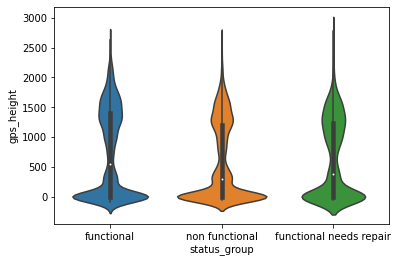

In [8]:
sns.violinplot(x='status_group', y='gps_height', data=df)
plt.show()

<AxesSubplot:xlabel='status_group', ylabel='amount_tsh'>

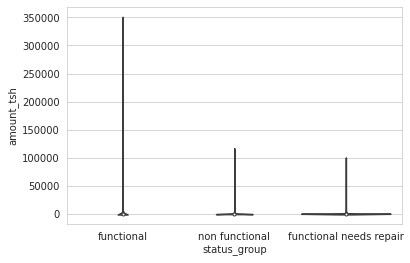

In [12]:
sns.violinplot(x='status_group', y='amount_tsh', data=df)